# Dimensionality Reduction Notes

## Remaining Questions // Things to Look Into
* Is there a more space efficient way to store the expressions data than in the pandas dataframe oriented .csv it's currently in, or should we just compress it for the cloud and uncompress it when we're working with it?
* yes. these links: https://towardsdatascience.com/the-best-format-to-save-pandas-data-414dca023e0d, https://towardsdatascience.com/stop-persisting-pandas-data-frames-in-csvs-f369a6440af5, and https://analyticsindiamag.com/complete-guide-to-different-persisting-methods-in-pandas/. Seems like we should talk about these alternative formats as a group on Wednesday. 

* number of input variables (aka features)== dimensionality of dataset
* "Having a large number of dimensions in the feature space can mean that the volume of that space is very large, and in turn, the points that we have in that space (rows of data) often represent a small and non-representative sample. This can dramatically impact the performance of machine learning algorithms fit on data with many input features, generally referred to as the 'curse of dimensionality.'"
* https://scikit-learn.org/stable/auto_examples/neighbors/plot_nca_dim_reduction.html#sphx-glr-auto-examples-neighbors-plot-nca-dim-reduction-py 
* https://scikit-learn.org/stable/auto_examples/compose/plot_compare_reduction.html#sphx-glr-auto-examples-compose-plot-compare-reduction-py  
* https://www.codegrepper.com/code-examples/python/pandas+set+first+row+as+column+names 


### PCA Attempt
* have the expressions been standardized or z-score normalized? Should make a couple plots of their values to see. If not, they should be scaled before PCA 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.manifold import MDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier

feather_path = input('Enter path to local feather file: ')
tissue_df = pd.read_csv('https://raw.githubusercontent.com/HarritonResearchLab/genomics/main/exploring/first_topics/gene_prediction/tissue_prediction/data/tissue_df.csv')
tissues = np.array(tissue_df['tissue_ordinal'])
tissue_names = np.array(list(set(tissue_df['tissue_name'])))
feather_df = pd.read_feather(feather_path)

tissue_classes = {'cerebellum':0, 
                   'placenta':1,
                   'kidney':2, 
                   'endometrium':3,
                   'liver':4,
                   'colon':5,
                   'hippocampus':6}

plt.rcParams['font.family']='serif'

Technique: this is how I applied ordinal encoding with a dictionary: 

```python
tissue_classes = {'cerebellum':0, 
                   'placenta':1,
                   'kidney':2, 
                   'endometrium':3,
                   'liver':4,
                   'colon':5,
                   'hippocampus':6}

tissues_ordinal = np.array([tissue_classes[tissue] for tissue in tissues])
```

## PCA

In [8]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(feather_df).reshape(2,189)

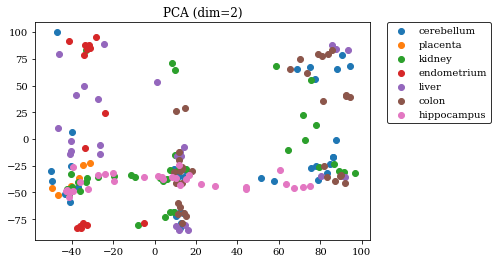

In [10]:
x_pca = X_pca[0]
y_pca = X_pca[1]

for item in tissue_classes.items(): 
    mask = np.where(tissues==item[1])
    plt.scatter(x_pca[mask], y_pca[mask],label=item[0])

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., edgecolor='black')
plt.title('PCA (dim=2)')
plt.show()

## MDS

In [12]:
mds = MDS(random_state=0)
X_mds = mds.fit_transform(feather_df).reshape((2,189))

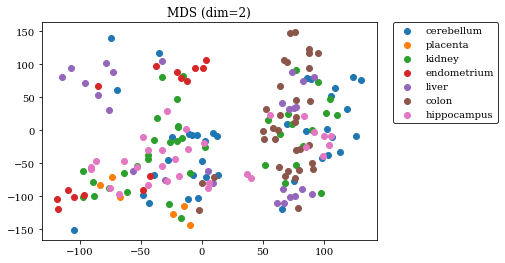

In [13]:
x_mds = X_mds[0]
y_mds = X_mds[1]

for item in tissue_classes.items(): 
    mask = np.where(tissues==item[1])
    plt.scatter(x_mds[mask], y_mds[mask],label=item[0])

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., edgecolor='black')
plt.title('MDS (dim=2)')
plt.show()

### MDS-KNN Grid Search

In [62]:
ks = [3, 5, 7, 9, 11, 13]
dims = [2, 4, 6, 8, 10]

models = []

for k in ks: 
    for dim in dims: 
        mds = MDS(random_state=3, n_components=dim)

        X_mds = mds.fit_transform(feather_df)
        
        new_df = pd.DataFrame(X_mds)

        X_train, X_test, y_train, y_test = train_test_split(new_df, tissues,test_size=0.15)

        knn = KNeighborsClassifier(k)
        knn.fit(X_train, y_train)
        predictions = knn.predict(X_test)

        acc = accuracy_score(predictions, y_test.flatten())

        models.append([k, dim, acc])

print(models)

[[3, 2, 0.9655172413793104], [3, 4, 1.0], [3, 6, 1.0], [3, 8, 1.0], [3, 10, 0.9655172413793104], [5, 2, 0.9655172413793104], [5, 4, 0.9655172413793104], [5, 6, 0.9655172413793104], [5, 8, 1.0], [5, 10, 1.0], [7, 2, 0.9310344827586207], [7, 4, 0.9655172413793104], [7, 6, 1.0], [7, 8, 1.0], [7, 10, 0.9655172413793104], [9, 2, 0.8620689655172413], [9, 4, 1.0], [9, 6, 1.0], [9, 8, 0.9655172413793104], [9, 10, 0.9655172413793104], [11, 2, 0.896551724137931], [11, 4, 1.0], [11, 6, 1.0], [11, 8, 1.0], [11, 10, 1.0], [13, 2, 0.7931034482758621], [13, 4, 1.0], [13, 6, 0.9310344827586207], [13, 8, 1.0], [13, 10, 0.9655172413793104]]


In [65]:
gs_results = pd.DataFrame(models, columns=['k', 'dim', 'acc'])
gs_results

,k,dim,acc
0,3,2,0.965517
1,3,4,1.000000
2,3,6,1.000000
3,3,8,1.000000
4,3,10,0.965517
5,5,2,0.965517
6,5,4,0.965517
7,5,6,0.965517
8,5,8,1.000000
9,5,10,1.000000


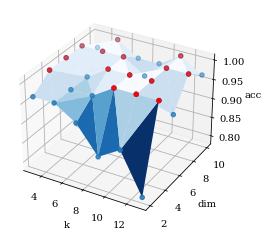

In [97]:
fig = plt.figure()

x = gs_results['k']
y = gs_results['dim']
z = gs_results['acc']

ax = plt.axes(projection='3d')
surface = ax.plot_trisurf(x, y, z, cmap='Blues_r')
ax.set_xlabel('k')
ax.set_ylabel('dim')
ax.set_zlabel('acc')

ax.scatter(x, y, z)

mask = np.where(z==np.max(z))[0]

ax.scatter(x[mask], y[mask], z[mask], color='red')

plt.show()

## Testing Reduced Input Size

In [4]:
print(feather_df)

     1007_s_at   1053_at    117_at     121_at  1255_g_at   1294_at   1316_at  \
0    10.191267  6.040463  7.447409  12.025042   5.269269  8.535176  6.921690   
1    10.509167  6.696075  7.775354  12.007817   5.180389  8.587241  6.962430   
2    10.272027  6.144663  7.696235  11.633279   5.301714  8.277414  7.054633   
3    10.252952  6.575153  8.478135  11.075286   5.372235  8.603650  7.115067   
4    10.157605  6.606701  8.116336  10.832528   5.334905  8.303227  7.078587   
..         ...       ...       ...        ...        ...       ...       ...   
184   9.803686  6.058488  7.486711   9.914632   5.312712  7.421166  6.906639   
185  10.509541  6.345526  7.468406   9.909784   5.341193  7.900080  6.982293   
186   9.984502  6.715984  7.120793   9.409933   4.896124  8.119396  6.810089   
187   9.937738  6.836179  7.125811   9.587782   5.296695  8.005432  6.976594   
188  10.306781  7.025547  7.407624   9.792904   5.206251  8.283758  7.123559   

      1320_at  1405_i_at   1431_at  ...

In [5]:
models = []

mds = MDS(random_state=0)

partition_sizes = [20, 100, 500, 1000, 10000]
ks = [3, 5, 7, 9, 11, 13]
dims = [2, 4, 6, 8, 10]
        
for dim in dims: 
    mds = MDS(random_state=3, n_components=dim)
    for k in ks: 
        for partition in partition_sizes: 
            
            average_acc = 0

            X_mds = mds.fit_transform(feather_df.iloc[:,0:partition])
            new_df = pd.DataFrame(X_mds)

            for iteration in range(2): 

                X_train, X_test, y_train, y_test = train_test_split(new_df, tissues,test_size=0.15)

                knn = KNeighborsClassifier(k)
                knn.fit(X_train, y_train)
                predictions = knn.predict(X_test)

                average_acc = average_acc + accuracy_score(predictions, y_test.flatten())

            average_acc = average_acc/2.0
            models.append([partition, k, dim, average_acc])

In [8]:
results_df = pd.DataFrame(models, columns=['Partition','k', 'dim', 'acc'])
print(results_df)
results_df.to_csv('results_df.csv')

     Partition   k  dim       acc
0           20   3    2  0.827586
1          100   3    2  0.775862
2          500   3    2  0.948276
3         1000   3    2  0.913793
4        10000   3    2  0.844828
..         ...  ..  ...       ...
145         20  13   10  0.879310
146        100  13   10  0.896552
147        500  13   10  0.913793
148       1000  13   10  0.896552
149      10000  13   10  0.982759

[150 rows x 4 columns]


In [18]:
partitions_arr, accs_arr = (np.array(results_df['Partition']), np.array(results_df['acc']))


mean_accs = np.array([])
partition_sizes = [20, 100, 500, 1000, 10000]
for partition_size in partition_sizes: 
    mask = np.where(partitions_arr==partition_size)[0]
    mean_accs = np.append(mean_accs, np.mean(accs_arr[mask]))

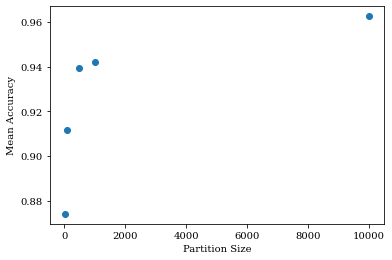

In [21]:
plt.scatter(partition_sizes, mean_accs)
plt.xlabel('Partition Size')
plt.ylabel('Mean Accuracy')
#plt.xscale('log')
plt.show()

## Concluding Thoughts
* ~~Thing to look into in the future: accuracy of model as the intial input dimension goes down (and perhaps as we have to predict the expressions of missing genes too).~~ 
* Which is the most predictive set of genes in each input dimension that yeilds the most accurate predictions?
    * Actually, a more insightful question would be this: what is the most computationally efficient method to identify the subset of genes in each in put dimension that produces the most accurate model? For example, if you wanted to find the hundred genes with the most predictive power and randomly tested all combinations of half of the genes in the dataset, to do so, you would have to test $ _n C _r=_{9999}C_{100}=6.5\cdot 10^{241} $ combinations. This may be where PCA is powerful. 